In [1]:
# import packages
import glob
from pathlib import Path
import scipy.stats
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
# import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pathos.threading import ThreadPool as Pool
from scipy.stats import gaussian_kde
import xarray as xr
from matplotlib import cm
import matplotlib
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# work_dir=Path("/scratch/fransjevanoors/global_sr")
work_dir=Path("/mnt/u/LSM root zone/global_sr")

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [5]:
# RUN SR CALCULATION 
catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]

# check which catchments are missing
c_list=[]
# for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/*.csv'):
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-10] # remove .year extension
    c_list.append(f)
dif = list(set(catch_list) - set(c_list))

# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60,70,80]
# f_array = ['0.9ia']
f_array = ['iwu2']
catch_id_list = dif
sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 
f_list = f_array * len(catch_id_list)

In [16]:
def sdmaxmin_noirri(catch_id,sd_dir):
    # check if sd exists for catchment id
    if(os.path.exists(f'{sd_dir}/no_irri/sd/{catch_id}.csv')==True):  

        # read storage deficit table
        sd_table = pd.read_csv(f'{sd_dir}/no_irri/sd/{catch_id}.csv',index_col=0)
        sd_table.index = pd.to_datetime(sd_table.index)

        # get sd, start and end year and date from sd_table
        if 'sd2' in sd_table.columns:
            Sd = sd_table.sd2
        else:
            Sd = sd_table.Sd

        year_start = sd_table.index[0].year
        year_end = sd_table.index[-1].year
        date_start = str(sd_table.index[0].month)+'-'+str(sd_table.index[0].day)
        date_end = str(sd_table.index[-1].month)+'-'+str(sd_table.index[-1].day)
        if(date_end=='2-29'):
            date_end='2-28'

    if ((year_end-year_start)>10) and (sd_table.Et.max()>0):#only if our timeseries is longer than 10years and Et is not nan
        # inverse of sd
        Sd = Sd*-1

        # count years
        total_years = year_end - year_start
        years = range(year_start,year_end+1,1)

        # calculate annual max Sd - without iterations for hydro years
        # CHECK THIS PROCEDURE AGAIN FRANSJE
        Sd_max=[]
        Sd_maxmin = []
        if (str(date_start)=='1-1'):
            for i in range(0,total_years+1,1):
                sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)]) #max value
                Sd_max.append(sd_max_i) #append max deficit per year
                # print(str(years[i])+'-'+str(date_start), str(years[i])+'-'+str(date_end))

                sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)].idxmax() #find index of max value
                sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
        else:
            for i in range(0,total_years,1):
                sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)]) #max value
                Sd_max.append(sd_max_i) #append max deficit per year
                # print(str(years[i])+'-'+str(date_start), str(years[i+1])+'-'+str(date_end))

                sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)].idxmax() #find index of max value
                sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
    return Sd_maxmin,date_start,date_end

In [17]:
def sdmaxmin_irri(catch_id,f,sd_dir):
    # check if sd exists for catchment id
    if(os.path.exists(f'{sd_dir}/irri/f{f}/sd/{catch_id}_f{f}.csv')==True):  

        # read storage deficit table
        sd_table = pd.read_csv(f'{sd_dir}/irri/f{f}/sd/{catch_id}_f{f}.csv',index_col=0)
        sd_table.index = pd.to_datetime(sd_table.index)

        # get sd, start and end year and date from sd_table
        if 'sd2' in sd_table.columns:
            Sd = sd_table.sd2
        else:
            Sd = sd_table.Sd

        year_start = sd_table.index[0].year
        year_end = sd_table.index[-1].year
        date_start = str(sd_table.index[0].month)+'-'+str(sd_table.index[0].day)
        date_end = str(sd_table.index[-1].month)+'-'+str(sd_table.index[-1].day)
        if(date_end=='2-29'):
            date_end='2-28'

    if ((year_end-year_start)>10) and (sd_table.Et.max()>0):#only if our timeseries is longer than 10years and Et is not nan
        # inverse of sd
        Sd = Sd*-1

        # count years
        total_years = year_end - year_start
        years = range(year_start,year_end+1,1)

        # calculate annual max Sd - without iterations for hydro years
        # CHECK THIS PROCEDURE AGAIN FRANSJE
        Sd_max=[]
        Sd_maxmin = []
        if (str(date_start)=='1-1'):
            for i in range(0,total_years+1,1):
                sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)]) #max value
                Sd_max.append(sd_max_i) #append max deficit per year
                # print(str(years[i])+'-'+str(date_start), str(years[i])+'-'+str(date_end))

                sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)].idxmax() #find index of max value
                sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
        else:
            for i in range(0,total_years,1):
                sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)]) #max value
                Sd_max.append(sd_max_i) #append max deficit per year
                # print(str(years[i])+'-'+str(date_start), str(years[i+1])+'-'+str(date_end))

                sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)].idxmax() #find index of max value
                sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
    return Sd_maxmin,date_start,date_end

    #         # calculate sr for different return periods using (4)
    #         sr_T = sr_return_periods_minmax_rzyear(rp_array, Sd, year_start, year_end, date_start, date_end)

    #         # store dataframe with catchment sr values
    #         sr_df = pd.DataFrame(index=[catch_id], columns=rp_array)
    #         sr_df.loc[catch_id]=sr_T

    #         sr_df.to_csv(f'{sd_dir}/irri/f{f}/sr/{catch_id}_f{f}.csv')

In [5]:
def gumbel(Sd_maxmin):
    m = len(Sd_maxmin)
    df = pd.DataFrame(index=np.arange(1,len(Sd_maxmin)+1,1),columns=['sd','i','p','q','y'])
    df['sd'] = Sd_maxmin
    df = df.sort_values('sd',ascending=False)
    df['i'] = np.arange(1,len(Sd_maxmin)+1,1)
    df['p'] = df['i']/(m+1)
    df['q'] = 1-df['p']
    df['y'] = -np.log(-np.log(df['q']))

    # exercise: compute Gumbel parameters (name them sigma and mu)
    s_R = df['sd'].std()
    s_y = df['y'].std()
    y_gem = df['y'].mean()
    R_max_gem = df['sd'].mean()
    sigma = s_R / s_y
    mu = R_max_gem - s_R * (y_gem / s_y)

    # Here we define the return periods and we inspect the difference between the two return periods
    T_interest = np.asarray([1,2,3,5,10,20,30,40,50,60,70,80])
    T_a_interest = 1 / (1-np.exp(-1/T_interest))

    # real return period for the observed annual maxima
    T_a = 1 / df.p
    df.loc[:,'T_a'] = T_a
    T = -1 / np.log(1 - 1/df['T_a'].values)
    df.loc[:,'T'] = T
    ix = find_nearest(T_a,2)
    
    # get sd value closest to T2 return period
    T2 = T_a[ix]
    sr = df.sd.values[ix]

    # exercise, Gumbel estimate for return period array T_interest
    # gumbel_estimate = sigma * (-np.log(1/T_interest)) + mu
    gumbel_estimate = sigma * (-np.log(-np.log(1-(1/T_interest)))) + mu
    
    return(df,T_a,gumbel_estimate,T2,sr)

In [19]:
def gumbel_plot(df1,T1,gumbel_estimate1, df2,T2,gumbel_estimate2,T):
    # create the figure
    T_interest = np.asarray([1,2,3,5,10,20,30,40,50,60,70,80])
        
    fig, ax = plt.subplots(figsize=(9,7))
    ax.plot(T1, df1['sd'].values,'xg', markersize=7, label='Observed Annual Maxima 1')
    ax.plot(T_interest, gumbel_estimate1, ':og', label = 'Gumbel Estimate 1')
    ax.plot(T2, df2['sd'].values,'xm', markersize=7, label='Observed Annual Maxima 2')
    ax.plot(T_interest, gumbel_estimate2, ':om', label = 'Gumbel Estimate2 ')
    ax.vlines(20,0,600)
    ax.set_xlabel('Return period (years)')
    ax.set_ylabel('Sd (mm)')
    ax.set_xscale('log')
    ax.legend(loc='best',framealpha=0.5)
    ax.grid(True)

In [20]:
# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'

1.04 111.12918236637996
1.04 124.15788011236468


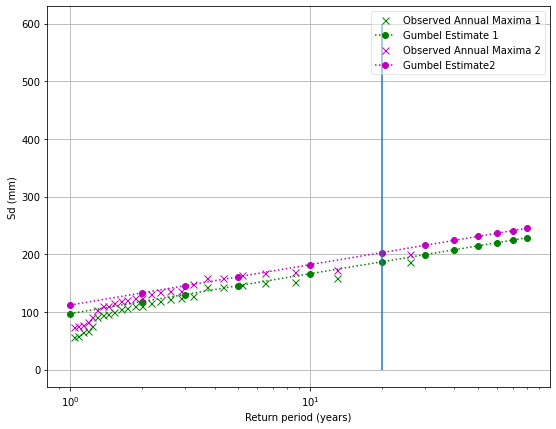

In [21]:
c0 = 'br_0002791'
c1 = 'us_0005570'
c5 = 'es_0000301'
c10 = 'in_0000134'

catch_id = c5
f='iwu2'
Sd_maxmin1 = sdmaxmin_irri(catch_id,f,sd_dir)[0]
Sd_maxmin2 = sdmaxmin_noirri(catch_id,sd_dir)[0]

df1,T1,gumbel_estimate1,T,sr = gumbel(Sd_maxmin1)
print(T,sr)

df2,T2,gumbel_estimate2,T,sr = gumbel(Sd_maxmin2)
print(T,sr)

gumbel_plot(df1,T1,gumbel_estimate1, df2,T2,gumbel_estimate2,T)

In [22]:
a = ['ITPIE186', 'ITTOS387', 'ITUMB275', 'ITTRE260', 'ITEMI039', 'ITTRE270', 'ITEMI114', 'ITEMI002', 'ITVEN429', 'ITTRE266', 'ITTOS364', 'ITTRE240', 'ITPIE168', 'ITTOS384', 'ITTOS403', 'ITEMI096', 'ITTOS358', 'ITTOS328', 'ITTOS349', 'ITEMI120']

1.855299614451385 277.90033157904213
1.786940292891443 274.2247308809584


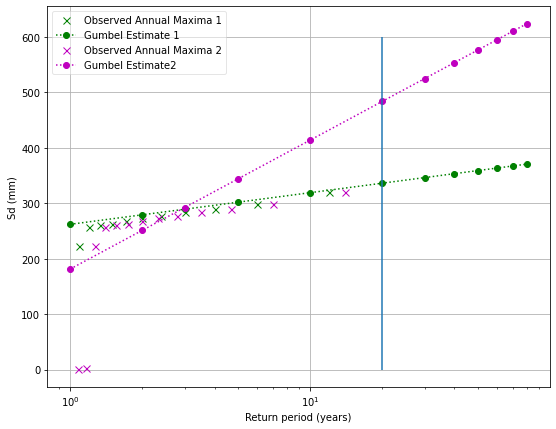

In [32]:
catch_id = a[6]
f='0.9ia'
Sd_maxmin1 = sdmaxmin_irri(catch_id,f,sd_dir)
Sd_maxmin2 = sdmaxmin_noirri(catch_id,sd_dir)

Sd_maxmin1 = [283.7502478242281,
 274.2247308809584,
 263.6082090061611,
 257.58075153655585,
 223.58733366691823,
 290.3168871649841,
 268.3949264391716,
 320.773035177016,
 260.84559959207076,
 277.90033157904213,
 299.1117588843288]

df1,T1,gumbel_estimate1,T,sr = gumbel(Sd_maxmin1)
print(T,sr)

df2,T2,gumbel_estimate2,T,sr = gumbel(Sd_maxmin2)
print(T,sr)

gumbel_plot(df1,T1,gumbel_estimate1, df2,T2,gumbel_estimate2,T)

1.9576151889712174 320.9446020429844
2.127643145234443 320.9446020429844


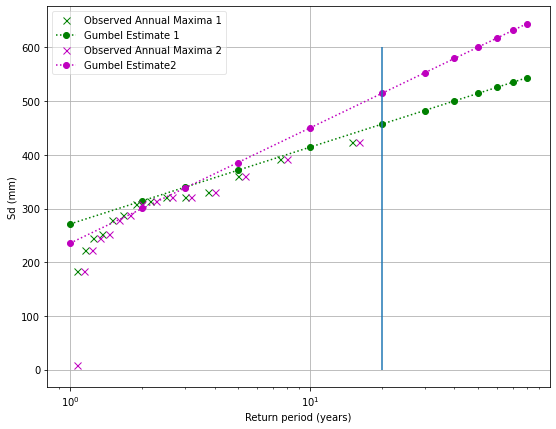

In [49]:
catch_id = a[14]
f='0.9ia'
Sd_maxmin1 = sdmaxmin_irri(catch_id,f,sd_dir)[0]
Sd_maxmin2 = sdmaxmin_noirri(catch_id,sd_dir)[0]
date_start,date_end = sdmaxmin_noirri(catch_id,sd_dir)[1],sdmaxmin_noirri(catch_id,sd_dir)[2]

Sd_maxmin1 = [320.9446020429844,
 313.4579511381563,
 222.4448196890478,
 392.5497894281784,
 322.07644209546464,
 278.0218600741622,
 184.17267350507643,
 361.32332235752546,
 307.66421982991506,
 245.24898282648348,
 423.82915464600677,
 331.0753175843092,
 252.03629651358426,
 287.5405900063116]

df1,T1,gumbel_estimate1,T,sr = gumbel(Sd_maxmin1)
print(T,sr)

df2,T2,gumbel_estimate2,T,sr = gumbel(Sd_maxmin2)
print(T,sr)

gumbel_plot(df1,T1,gumbel_estimate1, df2,T2,gumbel_estimate2,T)

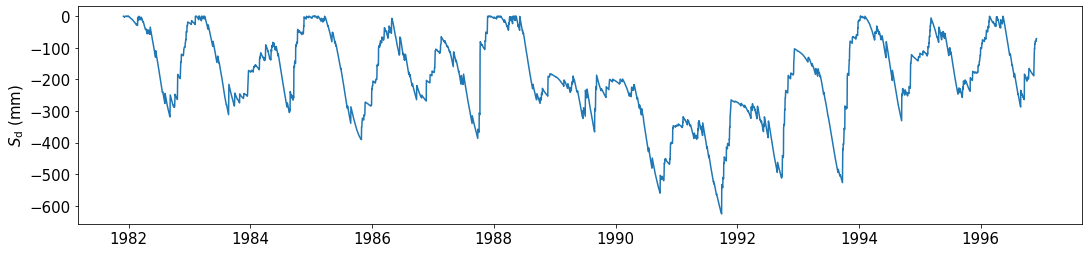

In [42]:
sd_fopt = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sd/{catch_id}_f0.9ia.csv',index_col=0)
sd_fopt.index = pd.to_datetime(sd_fopt.index)    

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax.plot(sd_fopt.index,sd_fopt.sd2,linewidth=1.5)
ax.set_ylabel('$S_\mathrm{d}$ (mm)', size=15)
ax.tick_params(axis='both', labelsize=15)

In [37]:
gumbel_estimate1

array([104.69662614, 125.37678698, 137.47390558, 152.7144726 ,
       173.39463344, 194.07479427, 206.17191287, 214.75495511,
       221.41247989, 226.85207371, 231.45118475, 235.43511595])

1.9576151889712174 127.6363663411656
1.9576151889712174 133.35352571317824


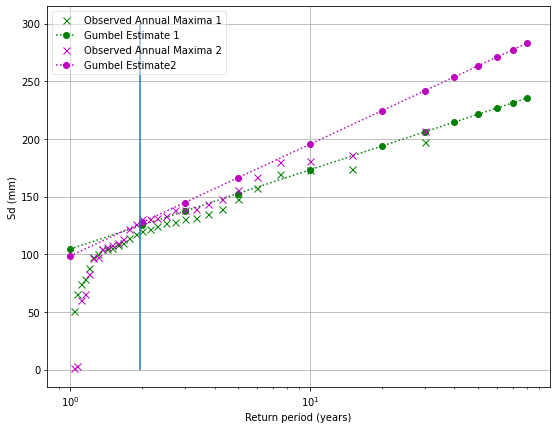

In [20]:
#catch list with catchments with Sr IWU > Sr NI
c_list = ['us_0004753', 'es_0000786', 'za_0000238', 'ca_0006320', 'se_0000041',
       'at_0000137', 'ca_0003756', 'br_0002437', 'fr_0001306', 'us_0005876',
       'mx_0000025', 'fr_0000730', 'ca_0006226', 'es_0000190', 'ch_0000044',
       'ca_0000774', 'ru_0000296', 'us_0006397', 'es_0000977', 'br_0001432',
       'na_0000040', 'ca_0002172', 'br_0001238', 'es_0000232', 'cz_0000030',
       'es_0001066', 'es_0000590', 'us_0005866', 'es_0001063', 'us_0005535',
       'th_0000180']
catch_id = c_list[18]
f='iwu2'
Sd_maxmin1 = sdmaxmin_irri(catch_id,f,sd_dir)
Sd_maxmin2 = sdmaxmin_noirri(catch_id,sd_dir)

df1,T1,gumbel_estimate1,T,sr = gumbel(Sd_maxmin1)
print(T,sr)

df2,T2,gumbel_estimate2,T,sr = gumbel(Sd_maxmin2)
print(T,sr)

gumbel_plot(df1,T1,gumbel_estimate1, df2,T2,gumbel_estimate2,T)

## TEST Sd -> Sr

In [6]:
from f_sr_calculation import *

In [7]:
def sr_return_periods_minmax_rzyear(rp_array,Sd,year_start,year_end,date_start,date_end):
    """
    calculate sr for different return periods - min max root zone year approach from Stijn??
    
    rp_array:   int, array, list of return periods
    sd:         pandas df, storage deficits
    year_start: str, start year
    year_end:   str, end year
    date_start: str, month-day start
    date_end:   str, month-day end
    
    returns:
    Sd_T:       list of storage deficit for return periods in rp_array
    
    """

    # inverse of sd
    Sd = Sd*-1
    
    # count years
    total_years = year_end - year_start
    years = range(year_start,year_end+1,1)

    # calculate annual max Sd - without iterations for hydro years
    # CHECK THIS PROCEDURE AGAIN FRANSJE
    Sd_max=[]
    Sd_maxmin = []
    if (str(date_start)=='1-1'):
        for i in range(0,total_years+1,1):
            sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)]) #max value
            Sd_max.append(sd_max_i) #append max deficit per year
            # print(str(years[i])+'-'+str(date_start), str(years[i])+'-'+str(date_end))

            sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)].idxmax() #find index of max value
            sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
            min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
            Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
    else:
        for i in range(0,total_years,1):
            sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)]) #max value
            Sd_max.append(sd_max_i) #append max deficit per year
            # print(str(years[i])+'-'+str(date_start), str(years[i+1])+'-'+str(date_end))

            sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)].idxmax() #find index of max value
            sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
            min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
            Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year

    # define root zone year
    sd_max_month = Sd.groupby(pd.Grouper(freq='M')).max() #calculate maximum sd per month
    sd_max_month_sum =  sd_max_month.groupby([sd_max_month.index.month]).sum() #sum max sd per month for full timeseries per month
    start_rz_year = sd_max_month_sum.idxmin() #define month where rz year starts
    date_start_rz_year = str(start_rz_year)+'-1'        
    if(start_rz_year==1):
        start_rz_year=13
    day_end_rz_year = calendar.monthrange(2010,start_rz_year-1)[1] #find last day of end month rz year
    date_end_rz_year = str(start_rz_year-1)+'-'+str(day_end_rz_year)

    # calculate annual max Sd - without iterations for rootzone years -> CHECK THIS APPROACH
    Sd_max_rz_year = []
    Sd_maxmin_rz_year = []
    if (str(date_start_rz_year)=='1-1'):
        for i in range(0,total_years+1,1):
            sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i])+'-'+str(date_end_rz_year)])
            Sd_max_rz_year.append(sd_max_i) #append max deficit per year
            # print(str(years[i])+'-'+str(date_start_rz_year), str(years[i])+'-'+str(date_end_rz_year))

            sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i])+'-'+str(date_end_rz_year)].idxmax() #find index of max value
            sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):sd_max_ix] #timeseries from start rzyear to index of max value
            min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
            Sd_maxmin_rz_year.append(sd_max_i-min_value) #append max-min sd per year
    else:
        for i in range(0,total_years,1):
            sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i+1])+'-'+str(date_end_rz_year)])
            Sd_max_rz_year.append(sd_max_i) #append max deficit per year
            # print(str(years[i])+'-'+str(date_start_rz_year), str(years[i+1])+'-'+str(date_end_rz_year))

            sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i+1])+'-'+str(date_end_rz_year)].idxmax() #find index of max value
            sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):sd_max_ix] #timeseries from start rzyear to index of max value
            min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
            Sd_maxmin_rz_year.append(sd_max_i-min_value) #append max-min sd per year        

    return(Sd_maxmin)

In [8]:
def run_sr_calculation(catch_id, rp_array, sd_dir,ir_case):
    """
    run sr calculation
    
    catch_id:   str, catchment id
    rp_array:   int, array, array of return periods
    sd_dir:     str, dir, directory with sd dataframes
    out_dir:    str, dir, output directory
    ir_case:    str, irrigation case 'ni', 'iaf', or 'iwu'
    
    returns:    sr_df, dataframe with sr for catchment, stored as csv
    
    """
    if (ir_case=='ni'):
        # check if sd exists for catchment id
        if(os.path.exists(f'{sd_dir}/no_irri/sd/{catch_id}.csv')==True):  

            # read storage deficit table
            sd_table = pd.read_csv(f'{sd_dir}/no_irri/sd/{catch_id}.csv',index_col=0)
            sd_table.index = pd.to_datetime(sd_table.index)

            # get sd, start and end year and date from sd_table
            if 'sd2' in sd_table.columns:
                Sd = sd_table.sd2
            else:
                Sd = sd_table.Sd

            year_start = sd_table.index[0].year
            year_end = sd_table.index[-1].year
            date_start = str(sd_table.index[0].month)+'-'+str(sd_table.index[0].day)
            date_end = str(sd_table.index[-1].month)+'-'+str(sd_table.index[-1].day)
            if(date_end=='2-29'):
                date_end='2-28'

            if ((year_end-year_start)>10) and (sd_table.Et.max()>0):#only if our timeseries is longer than 10years and Et is not nan
                # calculate sr for different return periods using (4)
                sd_maxmin = sr_return_periods_minmax_rzyear(rp_array, Sd, year_start, year_end, date_start, date_end)

                # get observed extremes as points
                df = gumbel(sd_maxmin)[0]
                # df.to_csv(f'{sd_dir}/no_irri/sr/{catch_id}_points.csv')

                # get gumbel fit for different T
                T_interest = gumbel(sd_maxmin)[1]
                gumbel_estimate = gumbel(sd_maxmin)[2]
                sr_df = pd.DataFrame(index=[catch_id], columns=T_interest)
                sr_df.loc[catch_id]=gumbel_estimate
                # sr_df.to_csv(f'{sd_dir}/no_irri/sr/{catch_id}_gumbelfit.csv')
                return(df,sr_df,sd_table)


In [23]:
def gumbel(Sd_maxmin):
    m = len(Sd_maxmin)
    df = pd.DataFrame(index=np.arange(1,len(Sd_maxmin)+1,1),columns=['sd','i','p','q','y'])
    df['sd'] = Sd_maxmin
    df = df.sort_values('sd',ascending=False)
    df['i'] = np.arange(1,len(Sd_maxmin)+1,1)
    df['p'] = df['i']/(m+1)
    df['q'] = 1-df['p']
    df['y'] = -np.log(-np.log(df['q']))

    # exercise: compute Gumbel parameters (name them sigma and mu)
    s_R = df['sd'].std()
    s_y = df['y'].std()
    y_gem = df['y'].mean()
    R_max_gem = df['sd'].mean()
    sigma = s_R / s_y
    mu = R_max_gem - s_R * (y_gem / s_y)

    # Here we define the return periods and we inspect the difference between the two return periods
    T_interest = np.asarray([1.1,1.5,2,3,5,10,20,30,40,50,60,70,80])
    T_a_interest = 1 / (1-np.exp(-1/T_interest))

    # real return period for the observed annual maxima
    T_a = 1 / df.p
    df.loc[:,'T_a'] = T_a
    T = -1 / np.log(1 - 1/df['T_a'].values)
    df.loc[:,'T'] = T

    # exercise, Gumbel estimate for return period array T_interest
    gumbel_estimate = sigma * (-np.log(-np.log(1-(1/T_interest)))) + mu
    
    return(df,T_interest,gumbel_estimate)

In [24]:
a = ['ITPIE186', 'ITTOS387', 'ITUMB275', 'ITTRE260', 'ITEMI039', 'ITTRE270', 'ITEMI114', 'ITEMI002', 'ITVEN429', 'ITTRE266', 'ITTOS364', 'ITTRE240', 'ITPIE168', 'ITTOS384', 'ITTOS403', 'ITEMI096', 'ITTOS358', 'ITTOS328', 'ITTOS349', 'ITEMI120']
catch_id = a[6]
catch_id

'ITEMI114'

In [25]:
dfg

,2,3,5,10,20,30,40,50,60,70,80
ITEMI114,218.505385,272.627467,332.907792,408.65214,481.307937,523.105024,552.573262,575.353413,593.926869,609.607793,623.176916


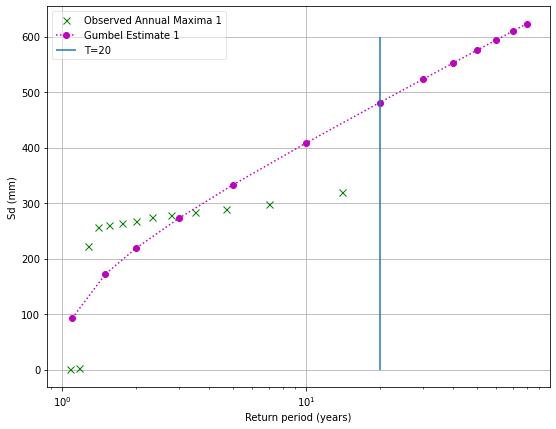

In [27]:
# max min
ir_case = 'ni'
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
rp_array = [1.1,1.5,2,3,5,10,20,30,40,50,60,70,80]
dfp = run_sr_calculation(catch_id, rp_array, sd_dir,ir_case)[0]
dfg = run_sr_calculation(catch_id, rp_array, sd_dir,ir_case)[1]

T_interest = np.asarray([1.1,1.5,2,3,5,10,20,30,40,50,60,70,80])
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(dfp['T_a'], dfp['sd'].values,'xg', markersize=7, label='Observed Annual Maxima 1')
ax.plot(T_interest, dfg.iloc[0].values, ':om', label = 'Gumbel Estimate 1')
ax.vlines(20,0,600, label='T=20')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Sd (mm)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

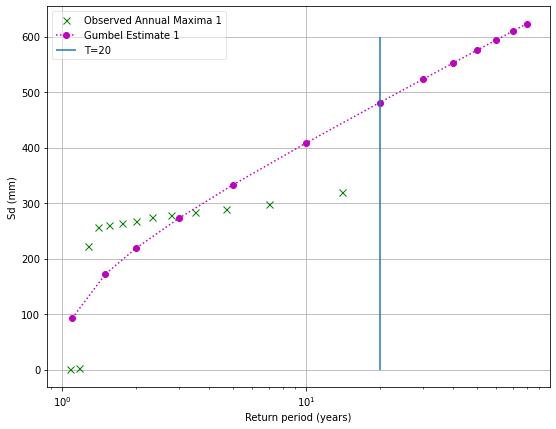

In [29]:
# max min root zone year
ir_case = 'ni'
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
rp_array = [1.1,1.5,2,3,5,10,20,30,40,50,60,70,80]
dfp = run_sr_calculation(catch_id, rp_array, sd_dir,ir_case)[0]
dfg = run_sr_calculation(catch_id, rp_array, sd_dir,ir_case)[1]

T_interest = np.asarray([1.1,1.5,2,3,5,10,20,30,40,50,60,70,80])
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(dfp['T_a'], dfp['sd'].values,'xg', markersize=7, label='Observed Annual Maxima 1')
ax.plot(T_interest, dfg.iloc[0].values, ':om', label = 'Gumbel Estimate 1')
ax.vlines(20,0,600, label='T=20')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Sd (mm)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

In [30]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
co = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
co = co.dropna()
catch_id = co.index[4200]

In [31]:
catch_id = a[6]

In [32]:
if (ir_case=='ni'):
    # check if sd exists for catchment id
    if(os.path.exists(f'{sd_dir}/no_irri/sd/{catch_id}.csv')==True):  

        # read storage deficit table
        sd_table = pd.read_csv(f'{sd_dir}/no_irri/sd/{catch_id}.csv',index_col=0)
        sd_table.index = pd.to_datetime(sd_table.index)

        # get sd, start and end year and date from sd_table
        if 'sd2' in sd_table.columns:
            Sd = sd_table.sd2
        else:
            Sd = sd_table.Sd

        year_start = sd_table.index[0].year
        year_end = sd_table.index[-1].year
        date_start = str(sd_table.index[0].month)+'-'+str(sd_table.index[0].day)
        date_end = str(sd_table.index[-1].month)+'-'+str(sd_table.index[-1].day)
        if(date_end=='2-29'):
            date_end='2-28'

        if ((year_end-year_start)>10) and (sd_table.Et.max()>0):#only if our timeseries is longer than 10years and Et is not nan
            # calculate sr for different return periods using (4)
            # sd_maxmin = sr_return_periods_minmax_rzyear(rp_array, Sd, year_start, year_end, date_start, date_end)
                # inverse of sd
            Sd = Sd*-1

            # count years
            total_years = year_end - year_start
            years = range(year_start,year_end+1,1)

            # calculate annual max Sd - without iterations for hydro years
            # CHECK THIS PROCEDURE AGAIN FRANSJE
            Sd_max=[]
            Sd_maxmin = []
            starts = []
            ends = []
            maxs = []
            if (str(date_start)=='1-1'):
                for i in range(0,total_years+1,1):
                    sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)]) #max value
                    Sd_max.append(sd_max_i) #append max deficit per year
                    # print(str(years[i])+'-'+str(date_start), str(years[i])+'-'+str(date_end))

                    sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i])+'-'+str(date_end)].idxmax() #find index of max value
                    sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                    min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                    Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
                    starts.append(str(years[i])+'-'+str(date_start))
                    ends.append(str(years[i])+'-'+str(date_end))
                    maxs.append(sd_max_ix)
            else:
                for i in range(0,total_years,1):
                    sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)]) #max value
                    Sd_max.append(sd_max_i) #append max deficit per year
                    # print(str(years[i])+'-'+str(date_start), str(years[i+1])+'-'+str(date_end))

                    sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start):str(years[i+1])+'-'+str(date_end)].idxmax() #find index of max value
                    sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start):sd_max_ix] #timeseries from start hydroyear to index of max value
                    min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                    Sd_maxmin.append(sd_max_i-min_value) #append max-min sd per year
                    starts.append(str(years[i])+'-'+str(date_start))
                    ends.append(str(years[i+1])+'-'+str(date_end))
                    maxs.append(sd_max_ix)
                
            # define root zone year
            sd_max_month = Sd.groupby(pd.Grouper(freq='M')).max() #calculate maximum sd per month
            sd_max_month_sum =  sd_max_month.groupby([sd_max_month.index.month]).sum() #sum max sd per month for full timeseries per month
            start_rz_year = sd_max_month_sum.idxmin() #define month where rz year starts
            date_start_rz_year = str(start_rz_year)+'-1'        
            if(start_rz_year==1):
                start_rz_year=13
            day_end_rz_year = calendar.monthrange(2010,start_rz_year-1)[1] #find last day of end month rz year
            date_end_rz_year = str(start_rz_year-1)+'-'+str(day_end_rz_year)
            
            if ((start_rz_year) < (sd_table.index[0].month)):
                year_start = year_start+1
            total_years = year_end - year_start
            years = range(year_start,year_end+1,1)

            # calculate annual max Sd - without iterations for rootzone years -> CHECK THIS APPROACH
            Sd_max_rz_year = []
            Sd_maxmin_rz_year = []
            starts_rz = []
            ends_rz = []
            maxs_rz = []
            if (str(date_start_rz_year)=='1-1'):
                for i in range(0,total_years+1,1):
                    sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i])+'-'+str(date_end_rz_year)])
                    Sd_max_rz_year.append(sd_max_i) #append max deficit per year
                    # print(str(years[i])+'-'+str(date_start_rz_year), str(years[i])+'-'+str(date_end_rz_year))

                    sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i])+'-'+str(date_end_rz_year)].idxmax() #find index of max value
                    sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):sd_max_ix] #timeseries from start rzyear to index of max value
                    min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                    Sd_maxmin_rz_year.append(sd_max_i-min_value) #append max-min sd per year
                    starts_rz.append(str(years[i])+'-'+str(date_start_rz_year))
                    ends_rz.append(str(years[i])+'-'+str(date_end_rz_year))
                    maxs_rz.append(sd_max_ix)
            else:
                for i in range(0,total_years,1):
                    sd_max_i = max(Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i+1])+'-'+str(date_end_rz_year)])
                    Sd_max_rz_year.append(sd_max_i) #append max deficit per year
                    # print(str(years[i])+'-'+str(date_start_rz_year), str(years[i+1])+'-'+str(date_end_rz_year))

                    sd_max_ix = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):str(years[i+1])+'-'+str(date_end_rz_year)].idxmax() #find index of max value
                    sd_hystart_maxvalue = Sd.loc[str(years[i])+'-'+str(date_start_rz_year):sd_max_ix] #timeseries from start rzyear to index of max value
                    min_value = min(sd_hystart_maxvalue) #find min value in timeseries before max value
                    Sd_maxmin_rz_year.append(sd_max_i-min_value) #append max-min sd per year  
                    starts_rz.append(str(years[i])+'-'+str(date_start_rz_year))
                    ends_rz.append(str(years[i])+'-'+str(date_end_rz_year))
                    maxs_rz.append(sd_max_ix)
            
            # get observed extremes as points
            df1 = gumbel(Sd_maxmin_rz_year)[0]
            df2 = gumbel(Sd_maxmin)[0]
            # df.to_csv(f'{sd_dir}/no_irri/sr/{catch_id}_points.csv')

            # get gumbel fit for different T
            T_interest = gumbel(Sd_maxmin_rz_year)[1]
            gumbel_estimate = gumbel(Sd_maxmin_rz_year)[2]
            sr_df1 = pd.DataFrame(index=[catch_id], columns=T_interest)
            sr_df1.loc[catch_id]=gumbel_estimate
            
            T_interest = gumbel(Sd_maxmin)[1]
            gumbel_estimate = gumbel(Sd_maxmin)[2]
            sr_df2 = pd.DataFrame(index=[catch_id], columns=T_interest)
            sr_df2.loc[catch_id]=gumbel_estimate

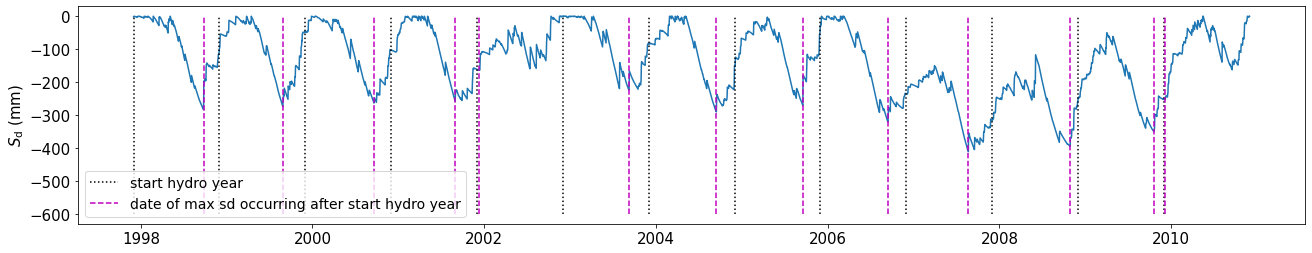

In [18]:
fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_table.index,sd_table.Sd,linewidth=1.5)
ax.vlines(starts,[-600]*len(starts),[0]*len(starts),color='k',linestyle=':',label='start hydro year')
ax.vlines(maxs,[-600]*len(maxs),[0]*len(maxs),color='m',linestyle='--',label='date of max sd occurring after start hydro year')
ax.set_ylabel('$S_\mathrm{d}$ (mm)', size=15)
ax.tick_params(axis='both', labelsize=15)
ax.legend(fontsize=14)

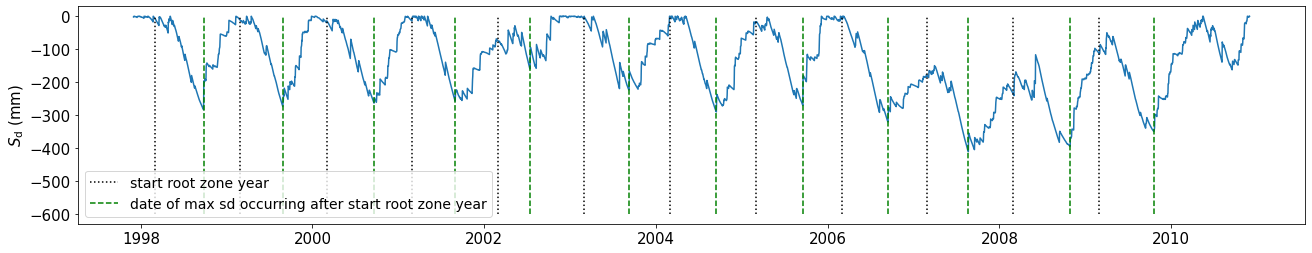

In [19]:
fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_table.index,sd_table.Sd,linewidth=1.5)
ax.vlines(starts_rz,[-600]*len(starts_rz),[0]*len(starts_rz),color='k',linestyle=':', label='start root zone year')
ax.vlines(maxs_rz,[-600]*len(maxs_rz),[0]*len(maxs_rz),color='g',linestyle='--', label='date of max sd occurring after start root zone year')
ax.set_ylabel('$S_\mathrm{d}$ (mm)', size=15)
ax.tick_params(axis='both', labelsize=15)
ax.legend(fontsize=14)

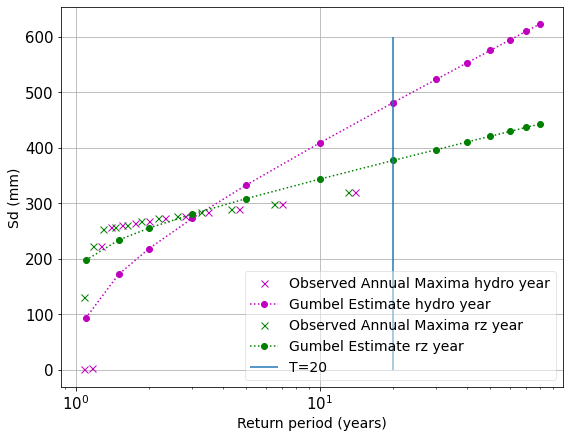

In [34]:
dfp1 = df1
dfg1 = sr_df1
dfp2 = df2
dfg2 = sr_df2

T_interest = np.asarray([1.1,1.5,2,3,5,10,20,30,40,50,60,70,80])
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(dfp2['T_a'], dfp2['sd'].values,'xm', markersize=7, label='Observed Annual Maxima hydro year')
ax.plot(T_interest, dfg2.iloc[0].values, ':om', label = 'Gumbel Estimate hydro year')
ax.plot(dfp1['T_a'], dfp1['sd'].values,'xg', markersize=7, label='Observed Annual Maxima rz year')
ax.plot(T_interest, dfg1.iloc[0].values, ':og', label = 'Gumbel Estimate rz year')
ax.vlines(20,0,600, label='T=20')
ax.set_xlabel('Return period (years)',size=14)
ax.set_ylabel('Sd (mm)',size=14)
ax.set_xscale('log')
ax.tick_params(axis='both', labelsize=15)
ax.legend(loc='best',framealpha=0.5,fontsize=14)
ax.grid(True)

In [ ]:
dfg2

In [86]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
co = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
co = co.dropna()
catch_id = co.index[4200]
df=co
lon_min,lon_max = -96,-95
lat_min,lat_max = 38,42
# lon_min,lon_max = -98,-97.5
# lat_min,lat_max = 38,42
df2 = df[(df.lon<lon_max)&(df.lon>lon_min)&(df.lat<lat_max)&(df.lat>lat_min)]

In [87]:
df2

,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,lat,lon,bp,dtb,pclay,psand,pcarb,bulk,stext,sr_20
us_0005227,2.710059,1.988387,1.551397,12.929151,1.362943,0.803417,37.649913,28.879426,4.30,23.23,...,38.5562,-95.9646,0.0,28.64,35.373114,18.362698,1.974228,164.777327,SiClLo,28.296398
us_0005230,2.818703,1.977205,1.790468,12.956927,0.701459,0.773433,37.412488,28.882233,4.11,22.89,...,38.6062,-95.6396,0.0,25.20,34.253587,16.709825,1.848839,166.089727,SiClLo,26.298998
us_0005231,2.775696,1.993267,1.547345,13.164044,0.718114,0.796162,37.450002,28.837222,4.23,23.40,...,38.7104,-95.8354,0.0,25.91,33.586541,19.315149,1.868619,164.125556,SiClLo,37.525932
us_0005165,2.599966,1.908912,1.449408,12.812094,0.734206,0.836080,39.231740,29.843582,4.28,24.17,...,39.5187,-95.5313,0.0,43.13,30.456104,20.603543,1.630651,164.157976,SaClLo,30.032889
us_0005166,2.688436,1.949188,1.509091,13.056041,0.725027,0.819606,38.607047,29.479285,4.21,23.80,...,39.0854,-95.3979,0.0,39.09,29.748988,22.207726,1.706545,164.041535,SaClLo,31.311929
us_0005164,2.690614,1.966104,1.587019,13.026117,0.730727,0.816614,38.487448,29.405746,4.30,24.47,...,39.1021,-95.7229,0.0,38.82,31.340466,21.553927,1.736990,164.877145,SiClLo,18.982859


Text(0.5, 1.0, '')

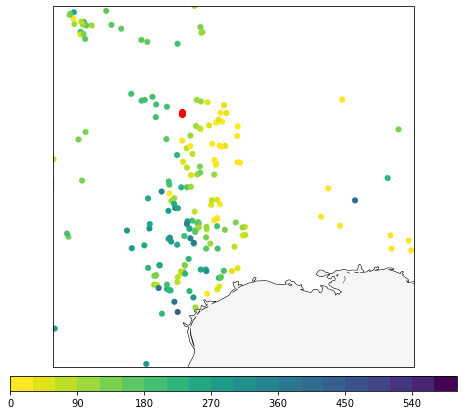

In [82]:
cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,600,21)
bounds2 = np.linspace(0,600,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
# ax.set_xlim(-180,180)
# ax.set_ylim(-60,90)
ax.set_xlim(-105,-85)
ax.set_ylim(25,45)
s = ax.scatter(df.lon,df.lat,c=df['sr_20'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
ax.plot(df2.lon,df2.lat,'ro')
# ax.plot(lon,lat,'mo')
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.02,aspect=30, norm=norm)
ax.set_title('',size=14)


In [60]:
catch_id = df2.index[5]
ir_case = 'ni'
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
rp_array = [2,3,5,10,20,30,40,50,60,70,80]

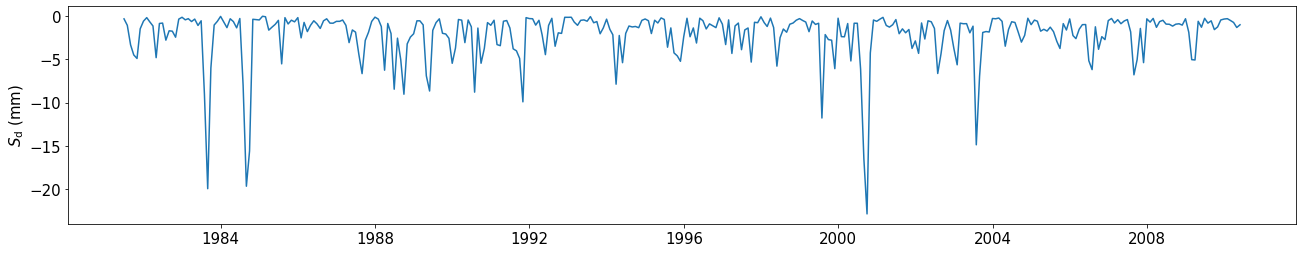

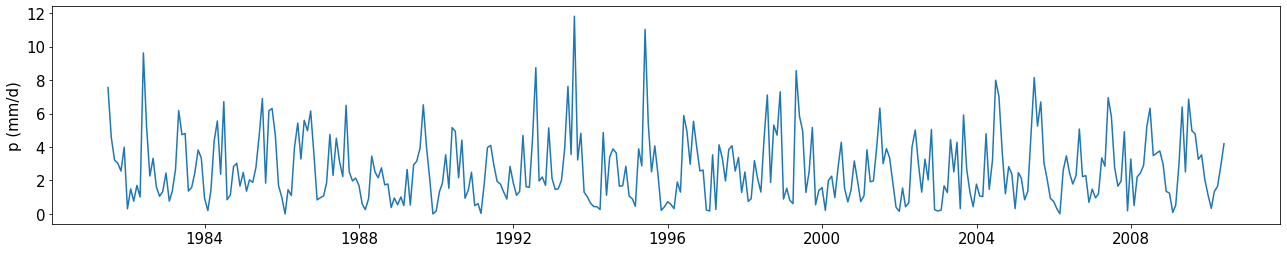

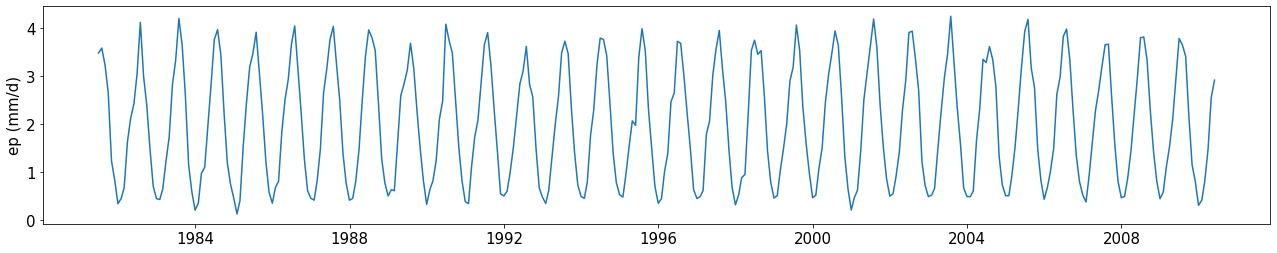

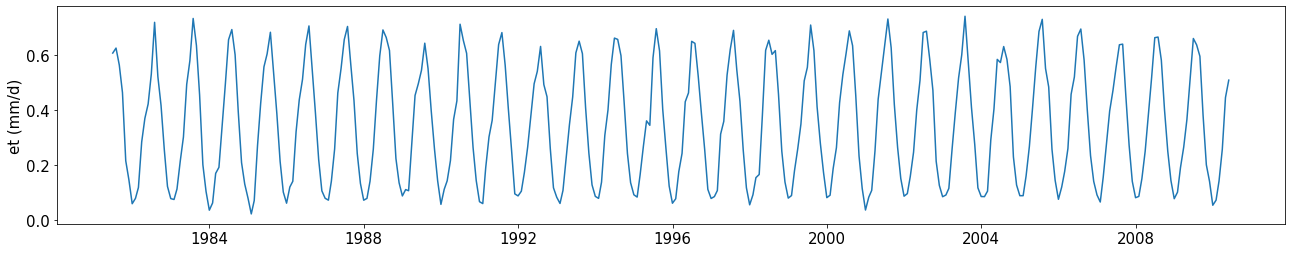

In [88]:
catch_id = 'us_0005227'
sd_table = pd.read_csv(f'{sd_dir}/no_irri/sd/{catch_id}.csv',index_col=0)
sd_table.index = pd.to_datetime(sd_table.index)
sd_tablem =sd_table.groupby(pd.Grouper(freq="M")).mean()

fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_tablem.index,sd_tablem.Sd,linewidth=1.5)
ax.set_ylabel('$S_\mathrm{d}$ (mm)', size=15)
ax.tick_params(axis='both', labelsize=15)

fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_tablem.index,sd_tablem.p,linewidth=1.5)
ax.set_ylabel('p (mm/d)', size=15)
ax.tick_params(axis='both', labelsize=15)

fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_tablem.index,sd_tablem.ep,linewidth=1.5)
ax.set_ylabel('ep (mm/d)', size=15)
ax.tick_params(axis='both', labelsize=15)

fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_tablem.index,sd_tablem.Et,linewidth=1.5)
ax.set_ylabel('et (mm/d)', size=15)
ax.tick_params(axis='both', labelsize=15)

In [89]:
df2.loc[catch_id]

p_mean       2.710059
ep_mean      1.988387
q_mean       1.551397
t_mean      12.929151
ai           1.362943
              ...    
psand       18.362698
pcarb        1.974228
bulk       164.777327
stext          SiClLo
sr_20       28.296398
Name: us_0005227, Length: 73, dtype: object

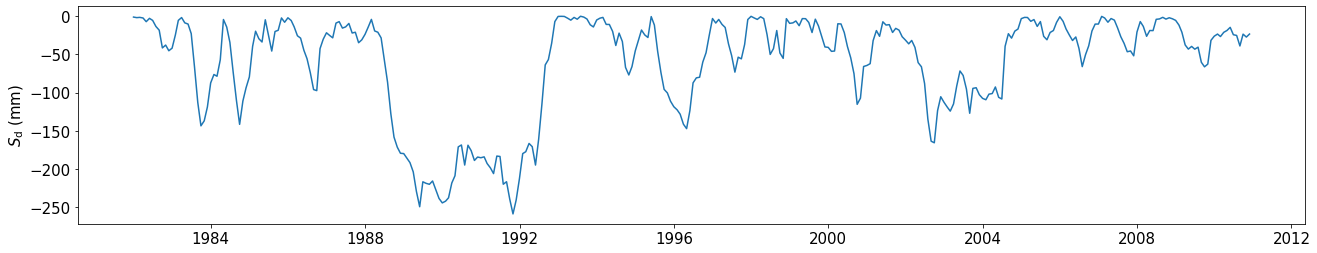

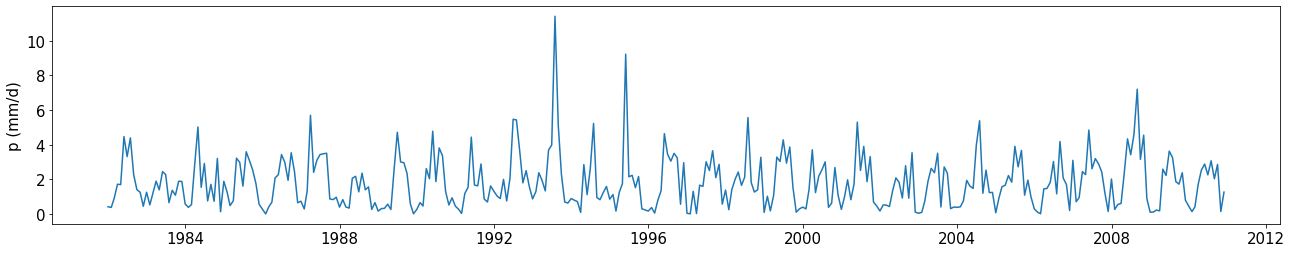

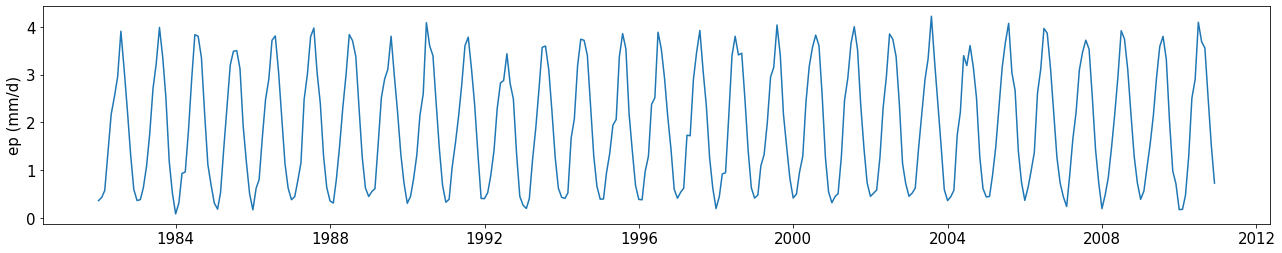

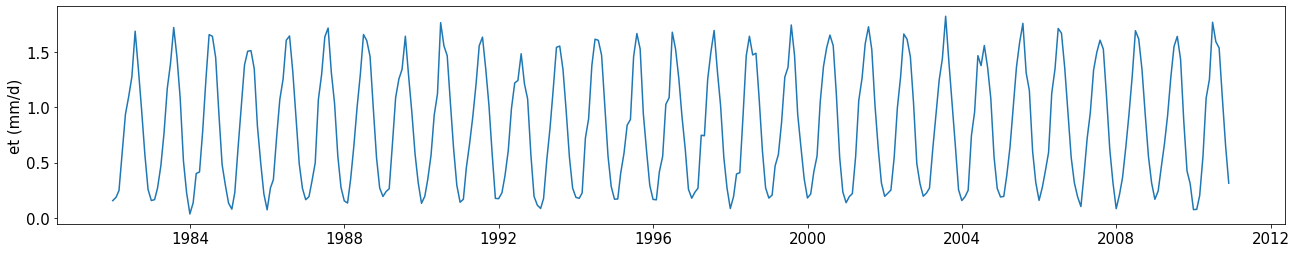

In [83]:
catch_id = 'us_0005117'
sd_table = pd.read_csv(f'{sd_dir}/no_irri/sd/{catch_id}.csv',index_col=0)
sd_table.index = pd.to_datetime(sd_table.index)
sd_tablem =sd_table.groupby(pd.Grouper(freq="M")).mean()

fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_tablem.index,sd_tablem.Sd,linewidth=1.5)
ax.set_ylabel('$S_\mathrm{d}$ (mm)', size=15)
ax.tick_params(axis='both', labelsize=15)

fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_tablem.index,sd_tablem.p,linewidth=1.5)
ax.set_ylabel('p (mm/d)', size=15)
ax.tick_params(axis='both', labelsize=15)

fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_tablem.index,sd_tablem.ep,linewidth=1.5)
ax.set_ylabel('ep (mm/d)', size=15)
ax.tick_params(axis='both', labelsize=15)

fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
ax.plot(sd_tablem.index,sd_tablem.Et,linewidth=1.5)
ax.set_ylabel('et (mm/d)', size=15)
ax.tick_params(axis='both', labelsize=15)

In [84]:
df.loc[catch_id]

p_mean        1.84063
ep_mean      1.917483
q_mean       0.190542
t_mean      12.357282
ai           1.041754
              ...    
psand       30.146069
pcarb        1.276387
bulk       159.787431
stext          SaClLo
sr_20      179.577782
Name: us_0005117, Length: 73, dtype: object

In [101]:
d=df[(df.q_mean/df.p_mean)<0.05].sort_index()

In [108]:
d[17:77]

,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,lat,lon,bp,dtb,pclay,psand,pcarb,bulk,stext,sr_20
ITEMI002,2.445965,1.806515,0.075105,10.862823,1.353969,0.728356,23.500001,20.553333,7.04,36.37,...,44.507477,11.470171,0.000000,15.51,35.061084,26.697550,3.191641,139.090423,SiClLo,513.603127
ITEMI043,2.122354,1.754393,0.076179,12.421524,0.826626,0.952739,24.596488,21.525771,7.15,34.44,...,44.577447,11.875204,0.000000,22.77,34.146634,24.967835,2.335120,143.365614,SiClLo,377.324643
ITEMI062,2.206990,2.031240,0.020010,10.763846,0.920367,0.800754,23.262633,20.507448,7.07,33.86,...,44.475627,11.281103,0.000000,13.60,32.474670,30.414950,4.411793,134.136339,SiClLo,458.122247
ITEMI086,2.336752,2.021997,0.069493,10.879085,1.155665,0.760570,22.736444,19.806779,6.30,33.23,...,44.121457,12.061551,0.000000,13.50,33.123554,28.889760,3.762696,136.378066,SiClLo,424.770832
ITEMI096,2.236851,1.795276,0.072667,12.393139,1.245965,0.901754,23.999731,21.316717,7.29,36.07,...,44.458760,11.735952,0.000000,18.69,35.970834,25.834833,2.605247,145.918084,ClLo,513.964544
ITEMI101,2.353605,1.771193,0.062080,11.261755,1.328825,0.783221,23.874409,20.848553,6.92,35.07,...,44.547360,11.133014,0.000000,17.63,35.831395,25.931015,2.846277,143.347341,ClLo,488.527605
ITLOM123,3.489758,1.452873,0.173533,5.285154,2.401971,0.286794,21.953715,18.263039,4.42,22.50,...,45.319080,9.508685,0.022375,16.25,19.288920,45.049364,5.988168,130.792429,Lo,335.544795
ITLOM131,3.634601,1.903143,0.133229,12.515944,1.909789,0.560356,23.500001,21.023077,5.99,33.08,...,45.635186,9.299103,0.000000,21.24,25.295088,37.852175,3.520906,137.355146,Lo,715.033235
ITLOM133,3.634601,1.864493,0.171968,12.515944,1.949378,0.560356,23.500001,21.023077,5.99,33.08,...,45.491633,9.248738,0.000000,22.17,24.609738,36.926804,2.788637,139.362026,Lo,732.995849
ITLOM137,3.027804,1.588067,0.070795,5.838074,1.906597,0.358567,23.305957,19.486774,4.77,24.27,...,45.392637,10.706292,0.000000,17.28,21.310582,42.952841,6.109692,128.998115,SiLo,399.665838


In [109]:
# check IT data

,ITEMI001,ITEMI002,ITEMI003,ITEMI004,ITEMI005,ITEMI006,ITEMI007,ITEMI008,ITEMI009,ITEMI010,...,ITVEN431,ITVEN432,ITVEN433,ITVEN434,ITVEN435,ITVEN436,ITVEN437,ITVEN438,ITVEN439,ITVEN440
1920-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.64,0.98,NaN,0.61,10.59,3.81,16.12,1.99,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.80,0.98,NaN,0.63,10.58,3.81,15.93,1.99,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.43,0.97,NaN,0.61,9.96,3.80,15.78,1.98,NaN
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.10,0.95,NaN,0.60,9.87,3.69,15.67,1.99,NaN


In [127]:
qm = ts['ITEMI101'].mean()
qm

1.2256212157907642

In [151]:
ts = pd.read_csv(f'{work_dir}/data/po_basin/organized_data/timeseries_ITo.csv',index_col=0)
c = pd.read_csv(f'{work_dir}/data/po_basin/organized_data/po_basin_characteristics.csv',index_col=0)
a = []
for i in c.index:
    a.append(ts[i].mean())
c['q_mean_raw'] = a
c['q_mean_mmday'] = c['q_mean_raw']/(c['area']*10e6)*1000*86400
c

,start_year,end_year,length,X,Y,area,area_calc_label,q_mean_raw,q_mean_mmday
ITEMI002,1979,2010,31,11.470171,44.507477,397.021,0,3.488967,0.075927
ITEMI009,1978,2010,32,10.905569,44.054038,39.472,0,1.644395,0.359940
ITEMI017,1987,2010,23,11.045084,44.727163,1047.108,0,16.937638,0.139757
ITEMI039,1997,2010,13,9.383694,44.755103,652.145,0,18.071977,0.239428
ITEMI043,1978,2005,27,11.875204,44.577447,2550.876,3,27.499379,0.093142
...,...,...,...,...,...,...,...,...,...
ITVEN429,1986,2010,24,12.547678,46.559269,131.348,0,3.620345,0.238144
ITVEN430,1985,2010,25,11.913261,46.011668,121.176,0,3.401386,0.242523
ITVEN433,1992,2010,18,12.108680,46.595520,81.405,0,2.437366,0.258692
ITVEN434,1995,2010,15,12.218303,46.134401,2018.155,0,19.775585,0.084662


Text(0.5, 1.0, 'q mean processed (mm/day?)')

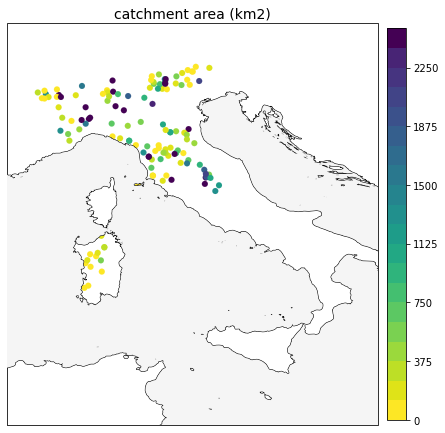

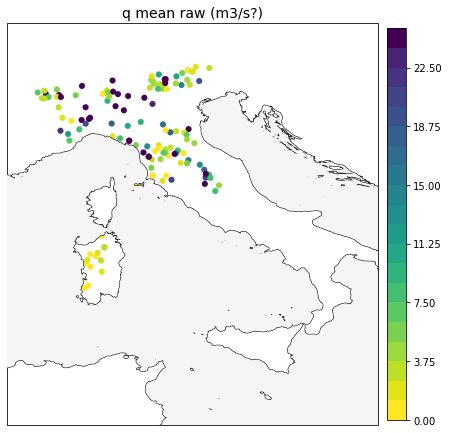

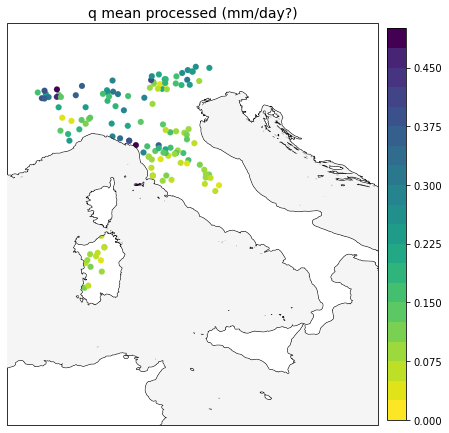

In [157]:
# Area
cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,2500,21)
bounds2 = np.linspace(0,2500,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(6,18)
ax.set_ylim(35,48)
s = ax.scatter(c.X,c.Y,c=c['area'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='neither', pad=0.02, norm=norm,shrink=0.9)
ax.set_title('catchment area (km2)',size=14)

# Q mean raw
cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,25,21)
bounds2 = np.linspace(0,25,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
# ax.set_xlim(-180,180)
# ax.set_ylim(-60,90)
ax.set_xlim(6,18)
ax.set_ylim(35,48)
s = ax.scatter(c.X,c.Y,c=c['q_mean_raw'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='neither', pad=0.02, norm=norm,shrink=0.9)
ax.set_title('q mean raw (m3/s?)',size=14)

# Q mean processed
cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,0.5,21)
bounds2 = np.linspace(0,0.5,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
# ax.set_xlim(-180,180)
# ax.set_ylim(-60,90)
ax.set_xlim(6,18)
ax.set_ylim(35,48)
s = ax.scatter(c.X,c.Y,c=c['q_mean_mmday'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='neither', pad=0.02, norm=norm,shrink=0.9)
ax.set_title('q mean processed (mm/day?)',size=14)

In [139]:
c.area.quantile(0.9)

2773.0538000000015